# Decision Trees

## Introduction

Decision Trees are versatile machine learning algorithms used for both classification and regression tasks. They work by recursively splitting the data based on features, creating a tree-like structure of decisions that leads to predictions.

In a decision tree:
- **Nodes**: Represent tests on attributes
- **Branches**: Represent outcomes of the tests
- **Leaf Nodes**: Represent class labels or predicted values

The key advantages of decision trees include:
- Easy to understand and interpret
- Require little data preprocessing
- Can handle both numerical and categorical data
- Can handle multi-output problems
- Uses a white box model (easy to explain)

The main algorithms for building decision trees are:
- **ID3** (Iterative Dichotomiser 3)
- **C4.5** (Successor of ID3)
- **CART** (Classification and Regression Trees) - Used in scikit-learn

These algorithms use metrics like **Gini Impurity**, **Information Gain**, or **Entropy** to determine the optimal splits.

In this notebook, we'll explore decision trees for both classification and regression tasks.

In [3]:
!pip install -q graphviz


[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
import graphviz
import joblib
import warnings

# Set up visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')
sns.set_palette('Set2')

# Set random seed for reproducibility
np.random.seed(42)

## PART I: Decision Tree Classification

### 1. Data Loading and Exploration - Iris Dataset

In [5]:
# Load the Iris dataset
iris = load_iris()
X_cls = pd.DataFrame(iris.data, columns=iris.feature_names)
y_cls = iris.target

# Display information about the dataset
print(f"Dataset shape: {X_cls.shape}")
print(f"Feature names: {iris.feature_names}")
print(f"Target names: {iris.target_names}")
print(f"Class distribution: {np.bincount(y_cls)}")

Dataset shape: (150, 4)
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']
Class distribution: [50 50 50]


In [6]:
# Create a DataFrame that includes the target variable
iris_df = X_cls.copy()
iris_df['species'] = [iris.target_names[i] for i in y_cls]

# Display the first few rows of the dataset
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [7]:
# Descriptive statistics
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


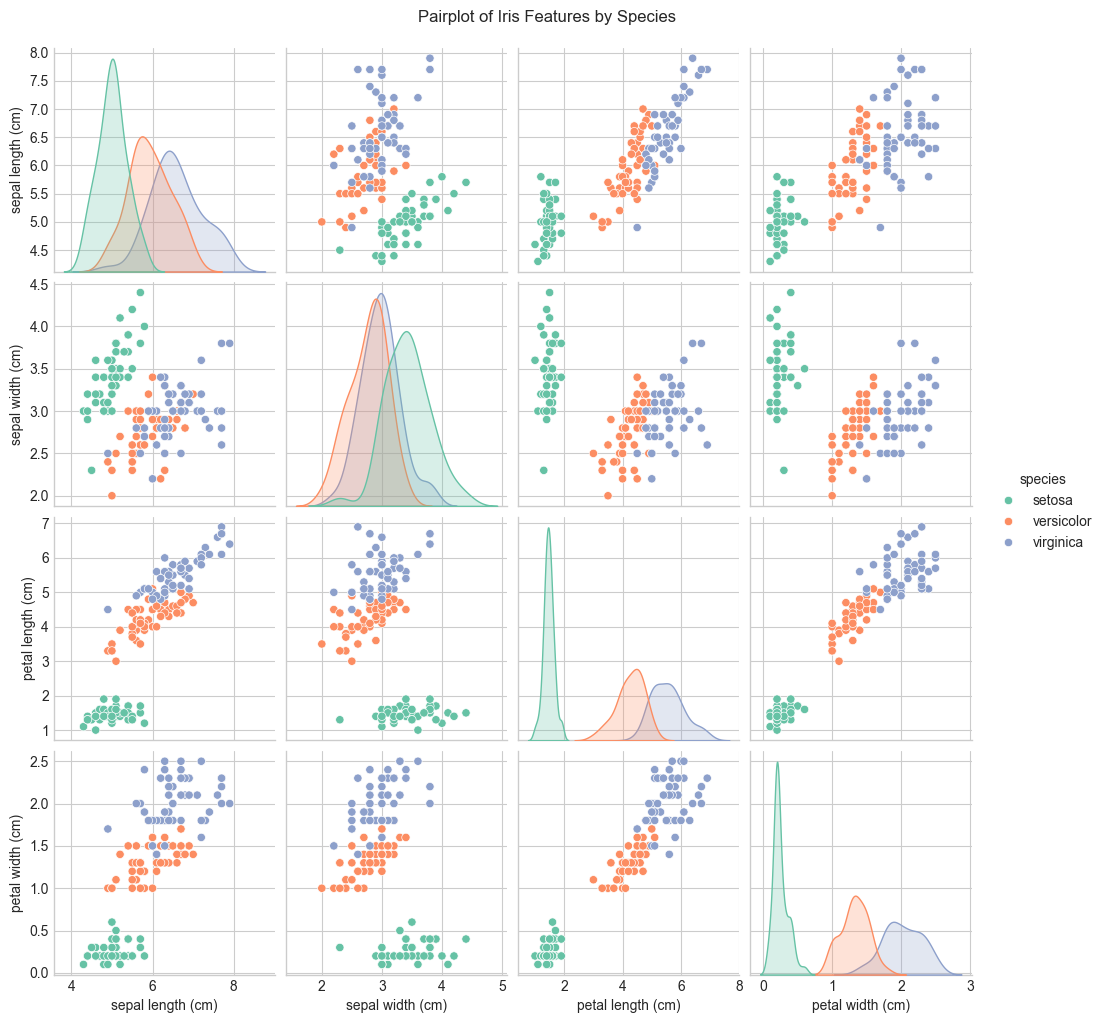

In [8]:
# Visualize the data
sns.pairplot(iris_df, hue='species', height=2.5)
plt.suptitle('Pairplot of Iris Features by Species', y=1.02)
plt.show()

### 2. Data Preprocessing

In [9]:
# Split the data into training and testing sets
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

print(f"Training set shape: {X_train_cls.shape}")
print(f"Testing set shape: {X_test_cls.shape}")
print(f"Training class distribution: {np.bincount(y_train_cls)}")
print(f"Testing class distribution: {np.bincount(y_test_cls)}")

Training set shape: (120, 4)
Testing set shape: (30, 4)
Training class distribution: [40 40 40]
Testing class distribution: [10 10 10]


Note: Decision trees don't require feature scaling since they make decisions based on thresholds rather than distances. However, we'll include this step for completeness and consistency with other algorithms.

In [10]:
# Feature scaling
scaler_cls = StandardScaler()
X_train_cls_scaled = scaler_cls.fit_transform(X_train_cls)
X_test_cls_scaled = scaler_cls.transform(X_test_cls)

# Convert back to DataFrames
X_train_cls_scaled_df = pd.DataFrame(X_train_cls_scaled, columns=X_cls.columns)
X_test_cls_scaled_df = pd.DataFrame(X_test_cls_scaled, columns=X_cls.columns)

print("First 5 rows of scaled training data:")
X_train_cls_scaled_df.head()

First 5 rows of scaled training data:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-1.721568,-0.332101,-1.345722,-1.323276
1,-1.124492,-1.227655,0.414505,0.651763
2,1.144395,-0.555990,0.584850,0.256755
3,-1.124492,0.115676,-1.288941,-1.454945
4,-0.408002,-1.227655,0.130598,0.125086


### 3. Building a Basic Decision Tree Classifier

Training Accuracy: 1.0000
Testing Accuracy: 0.9333


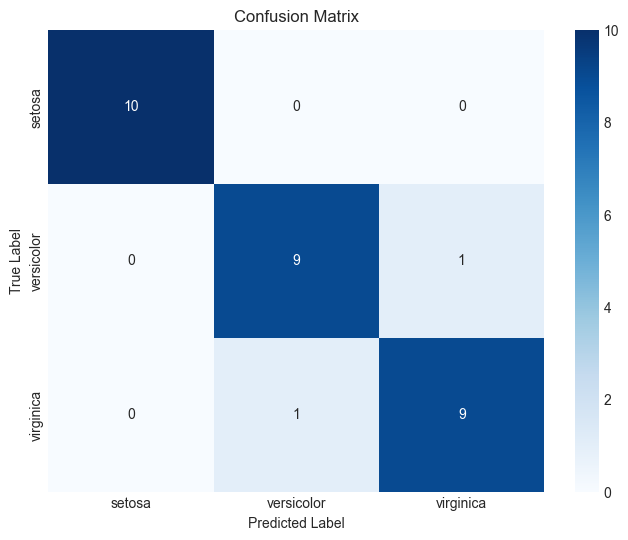

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [11]:
# Initialize and train a basic decision tree classifier
dt_cls = DecisionTreeClassifier(random_state=42)
dt_cls.fit(X_train_cls, y_train_cls)  # Note: using unscaled data as decision trees don't require scaling

# Make predictions
y_train_pred_cls = dt_cls.predict(X_train_cls)
y_test_pred_cls = dt_cls.predict(X_test_cls)

# Evaluate the model
train_accuracy_cls = accuracy_score(y_train_cls, y_train_pred_cls)
test_accuracy_cls = accuracy_score(y_test_cls, y_test_pred_cls)

print(f"Training Accuracy: {train_accuracy_cls:.4f}")
print(f"Testing Accuracy: {test_accuracy_cls:.4f}")

# Confusion matrix
cm_cls = confusion_matrix(y_test_cls, y_test_pred_cls)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cls, annot=True, fmt='d', cmap='Blues', 
            xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test_cls, y_test_pred_cls, target_names=iris.target_names))

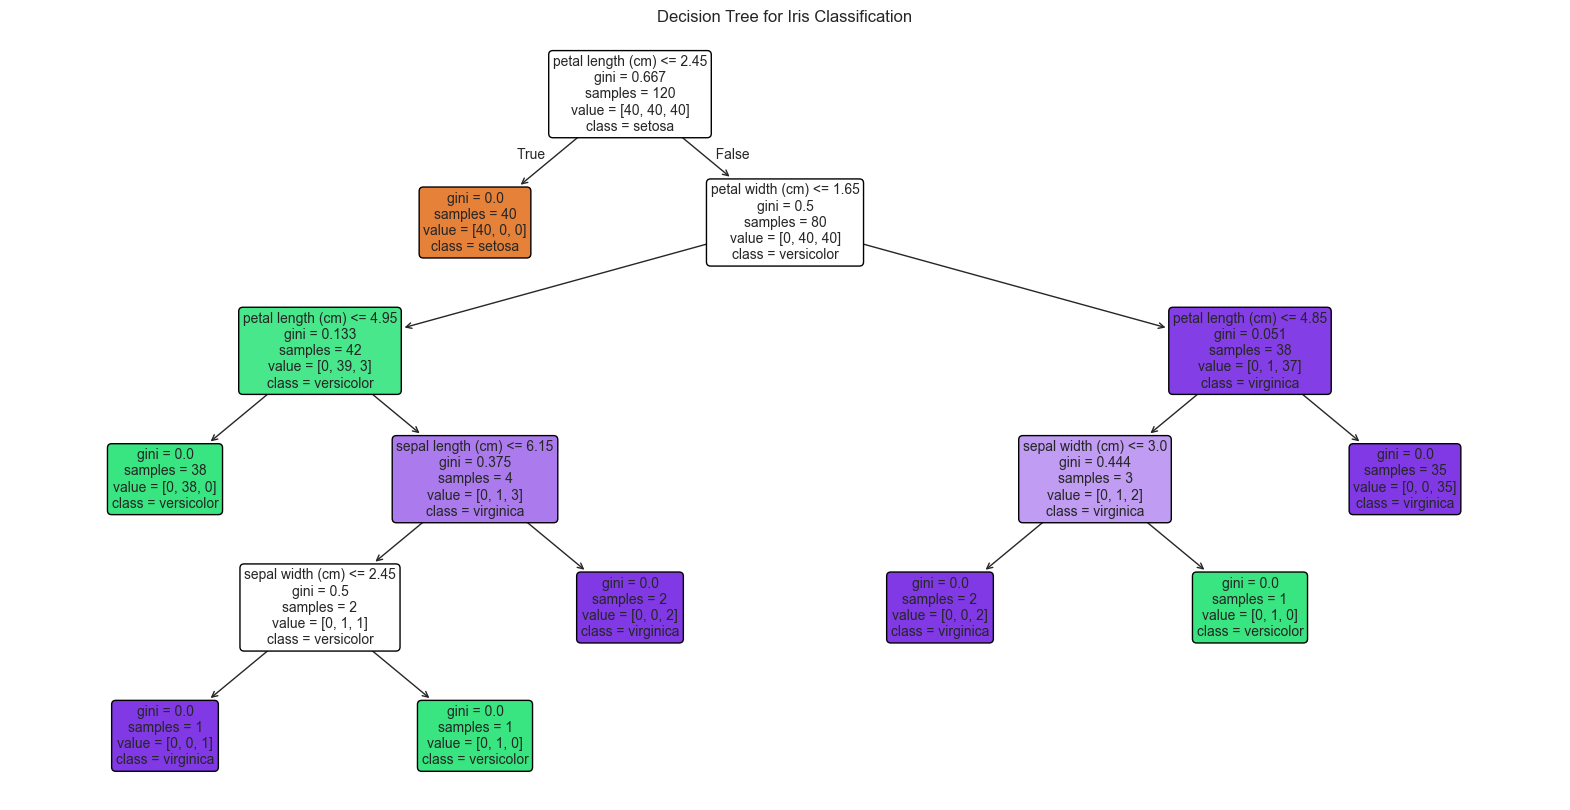

In [12]:
# Visualize the tree
plt.figure(figsize=(20, 10))
plot_tree(dt_cls, feature_names=iris.feature_names, class_names=iris.target_names, 
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree for Iris Classification')
plt.show()

We can see that the tree is quite complex, which may lead to overfitting. Let's examine if this is the case by comparing the training and testing accuracy.

In [13]:
# Check for overfitting
print(f"Difference between training and testing accuracy: {train_accuracy_cls - test_accuracy_cls:.4f}")
if train_accuracy_cls - test_accuracy_cls > 0.05:
    print("The model may be overfitting.")
else:
    print("The model seems well-balanced.")

Difference between training and testing accuracy: 0.0667
The model may be overfitting.


### 4. Hyperparameter Tuning

In [14]:
# Define hyperparameters grid
param_grid_cls = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# GridSearchCV
grid_search_cls = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_cls, cv=5, scoring='accuracy')
grid_search_cls.fit(X_train_cls, y_train_cls)

# Best parameters and score
print(f"Best parameters: {grid_search_cls.best_params_}")
print(f"Best cross-validation score: {grid_search_cls.best_score_:.4f}")

# Best model
best_dt_cls = grid_search_cls.best_estimator_

Best parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.9417


In [15]:
# Evaluate the best model
y_train_pred_best_cls = best_dt_cls.predict(X_train_cls)
y_test_pred_best_cls = best_dt_cls.predict(X_test_cls)

train_accuracy_best_cls = accuracy_score(y_train_cls, y_train_pred_best_cls)
test_accuracy_best_cls = accuracy_score(y_test_cls, y_test_pred_best_cls)

print(f"Best Model Training Accuracy: {train_accuracy_best_cls:.4f}")
print(f"Best Model Testing Accuracy: {test_accuracy_best_cls:.4f}")
print(f"Difference: {train_accuracy_best_cls - test_accuracy_best_cls:.4f}")

Best Model Training Accuracy: 1.0000
Best Model Testing Accuracy: 0.9333
Difference: 0.0667


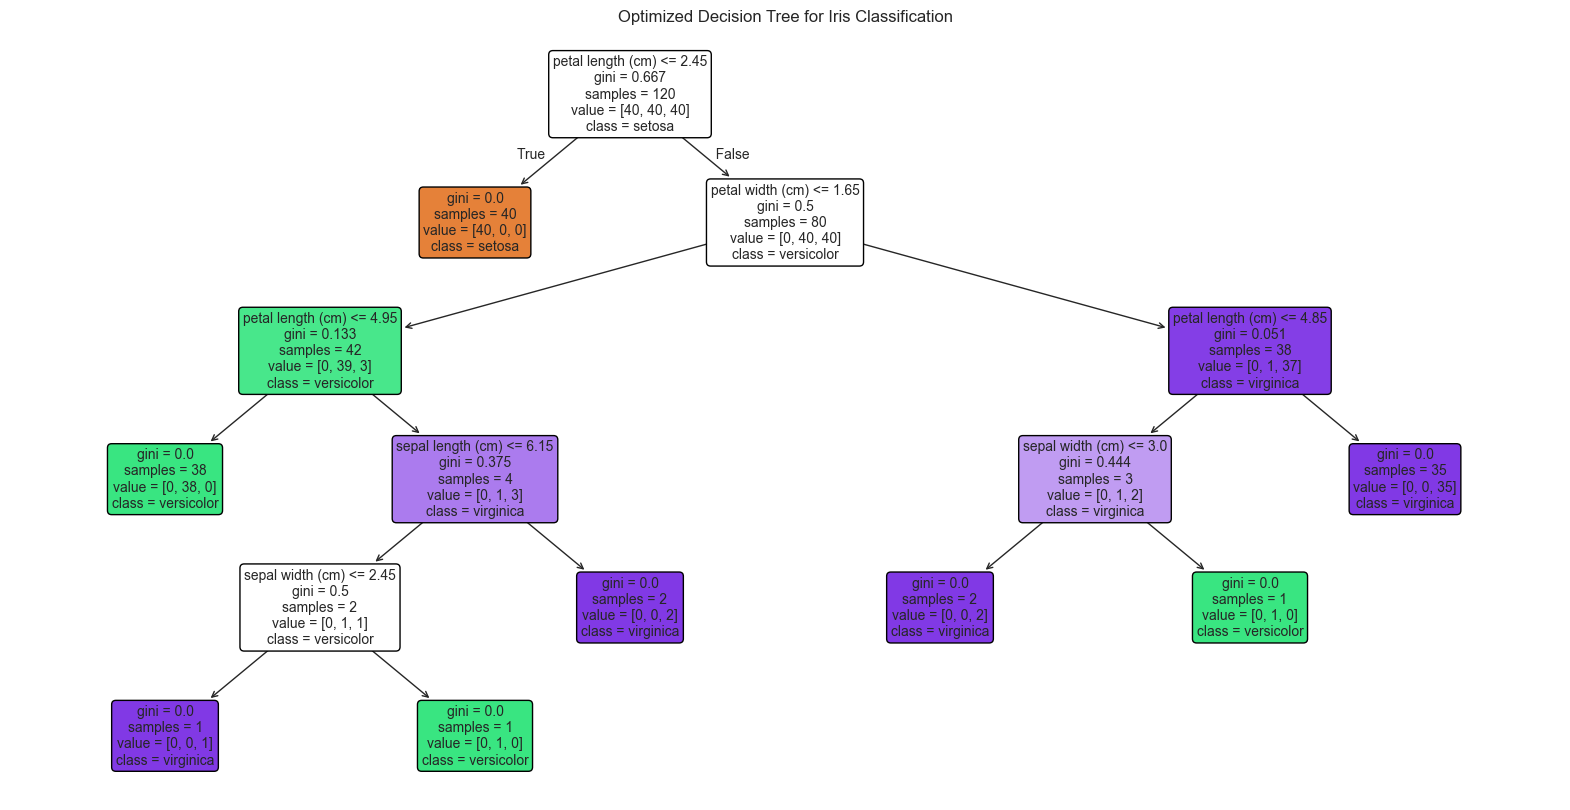

In [16]:
# Visualize the optimized tree
plt.figure(figsize=(20, 10))
plot_tree(best_dt_cls, feature_names=iris.feature_names, class_names=iris.target_names, 
          filled=True, rounded=True, fontsize=10)
plt.title('Optimized Decision Tree for Iris Classification')
plt.show()

### 5. Feature Importance

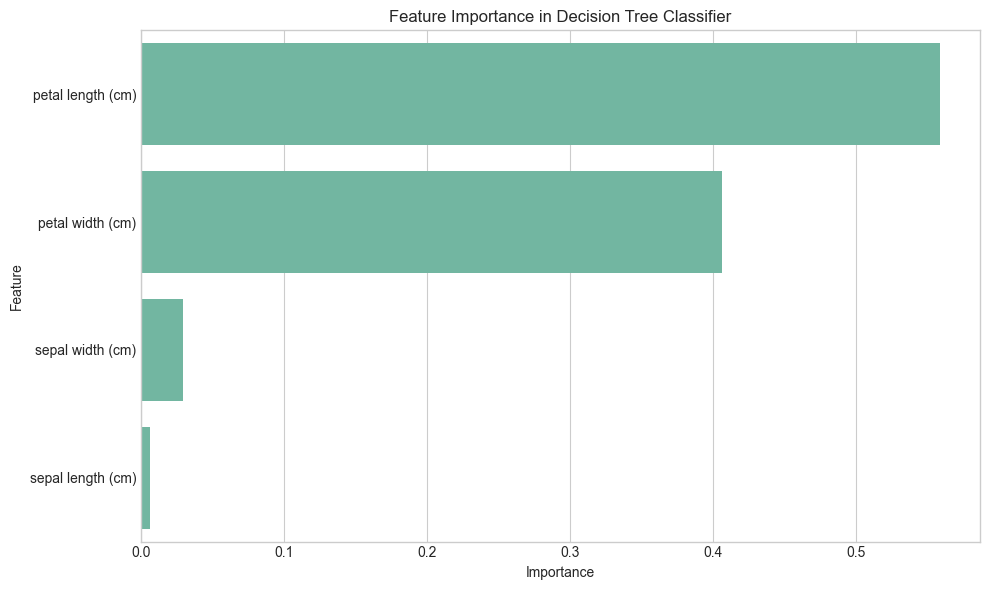

In [17]:
# Get feature importance
feature_importance_cls = pd.DataFrame({
    'Feature': iris.feature_names,
    'Importance': best_dt_cls.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_cls)
plt.title('Feature Importance in Decision Tree Classifier')
plt.tight_layout()
plt.show()

### 6. Cross-Validation and Learning Curves

In [18]:
# Perform 5-fold cross-validation
cv_scores_cls = cross_val_score(best_dt_cls, X_train_cls, y_train_cls, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores_cls}")
print(f"Mean CV score: {cv_scores_cls.mean():.4f}")
print(f"Standard deviation: {cv_scores_cls.std():.4f}")

Cross-validation scores: [0.91666667 0.95833333 0.95833333 0.95833333 0.91666667]
Mean CV score: 0.9417
Standard deviation: 0.0204


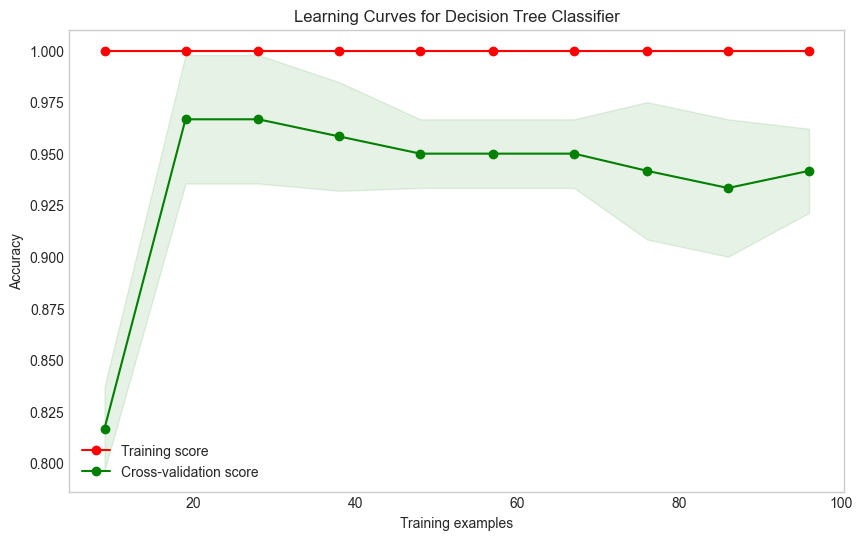

In [19]:
# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_dt_cls, X_train_cls, y_train_cls, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curves for Decision Tree Classifier")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

### 7. Decision Boundaries Visualization

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

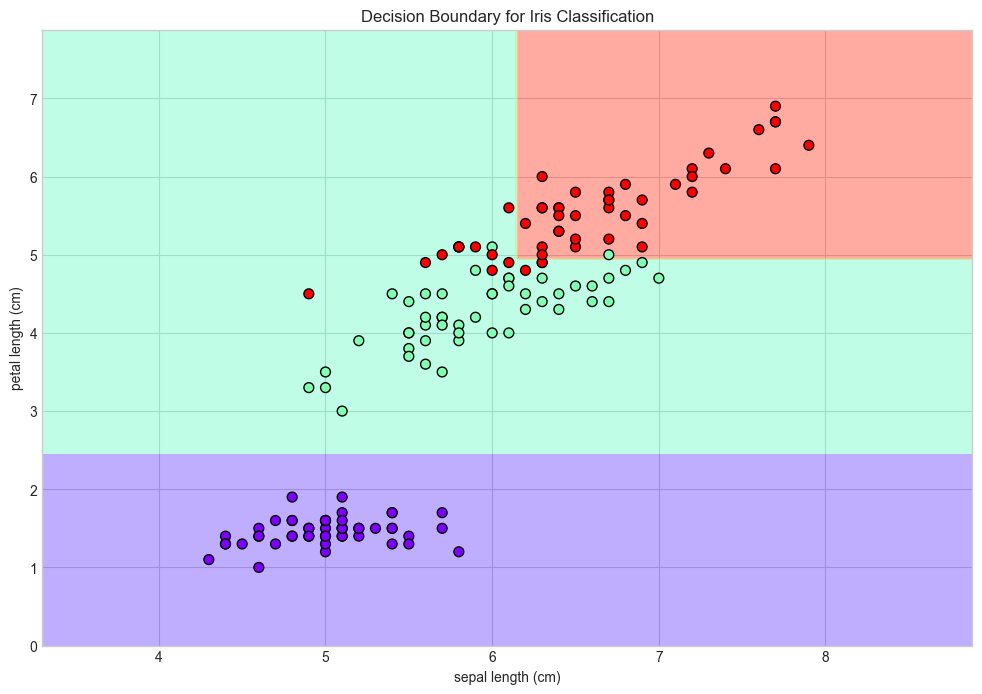

In [20]:
# Visualize decision boundaries in 2D (using the first 2 features)
def plot_decision_boundary(model, X, y, feature_names, class_names):
    # Select two features for visualization
    X_selected = X.iloc[:, [0, 2]].values  # sepal length and petal length
    
    # Set the mesh step size
    h = 0.02
    
    # Create meshgrid
    x_min, x_max = X_selected[:, 0].min() - 1, X_selected[:, 0].max() + 1
    y_min, y_max = X_selected[:, 1].min() - 1, X_selected[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Make predictions on the meshgrid points
    # For the prediction, we need to create a feature matrix with all 4 features
    # We'll use mean values for the other 2 features
    mean_features = np.mean(X.values, axis=0)
    meshgrid_features = np.c_[xx.ravel(), np.full(xx.ravel().shape, mean_features[1]), 
                            yy.ravel(), np.full(xx.ravel().shape, mean_features[3])]
    
    Z = model.predict(meshgrid_features)
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='rainbow')
    
    # Plot the data points
    scatter = plt.scatter(X_selected[:, 0], X_selected[:, 1], c=y, s=50, cmap='rainbow', edgecolor='black')
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[2])
    plt.title('Decision Boundary for Iris Classification')
    plt.legend(handles=scatter.legend_elements()[0], labels=class_names, title="Classes")
    plt.tight_layout()
    plt.show()

# Plot decision boundary
plot_decision_boundary(best_dt_cls, X_cls, y_cls, iris.feature_names, iris.target_names)

### 8. Export and Visualize the Tree with Graphviz

In [ ]:
# Export the tree to a graphviz file
dot_data = export_graphviz(best_dt_cls, out_file=None, 
                           feature_names=iris.feature_names,
                           class_names=iris.target_names,
                           filled=True, rounded=True, special_characters=True)

# Visualize the tree
graph = graphviz.Source(dot_data)
graph

### 9. Save the Model

In [ ]:
# Save the model
import os

if not os.path.exists('models'):
    os.makedirs('models')
    
joblib.dump(best_dt_cls, 'models/decision_tree_classifier.pkl')
print("Classifier model saved to 'models/decision_tree_classifier.pkl'")

## PART II: Decision Tree Regression

### 1. Data Loading and Exploration - Diabetes Dataset

In [21]:
# Load the Diabetes dataset
diabetes = load_diabetes()
X_reg = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y_reg = diabetes.target

# Display information about the dataset
print(f"Dataset shape: {X_reg.shape}")
print(f"Feature names: {diabetes.feature_names}")
print("Target: Disease progression measure")

Dataset shape: (442, 10)
Feature names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
Target: Disease progression measure


In [22]:
# Create a DataFrame that includes the target variable
diabetes_df = X_reg.copy()
diabetes_df['target'] = y_reg

# Display the first few rows of the dataset
diabetes_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [23]:
# Descriptive statistics
diabetes_df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


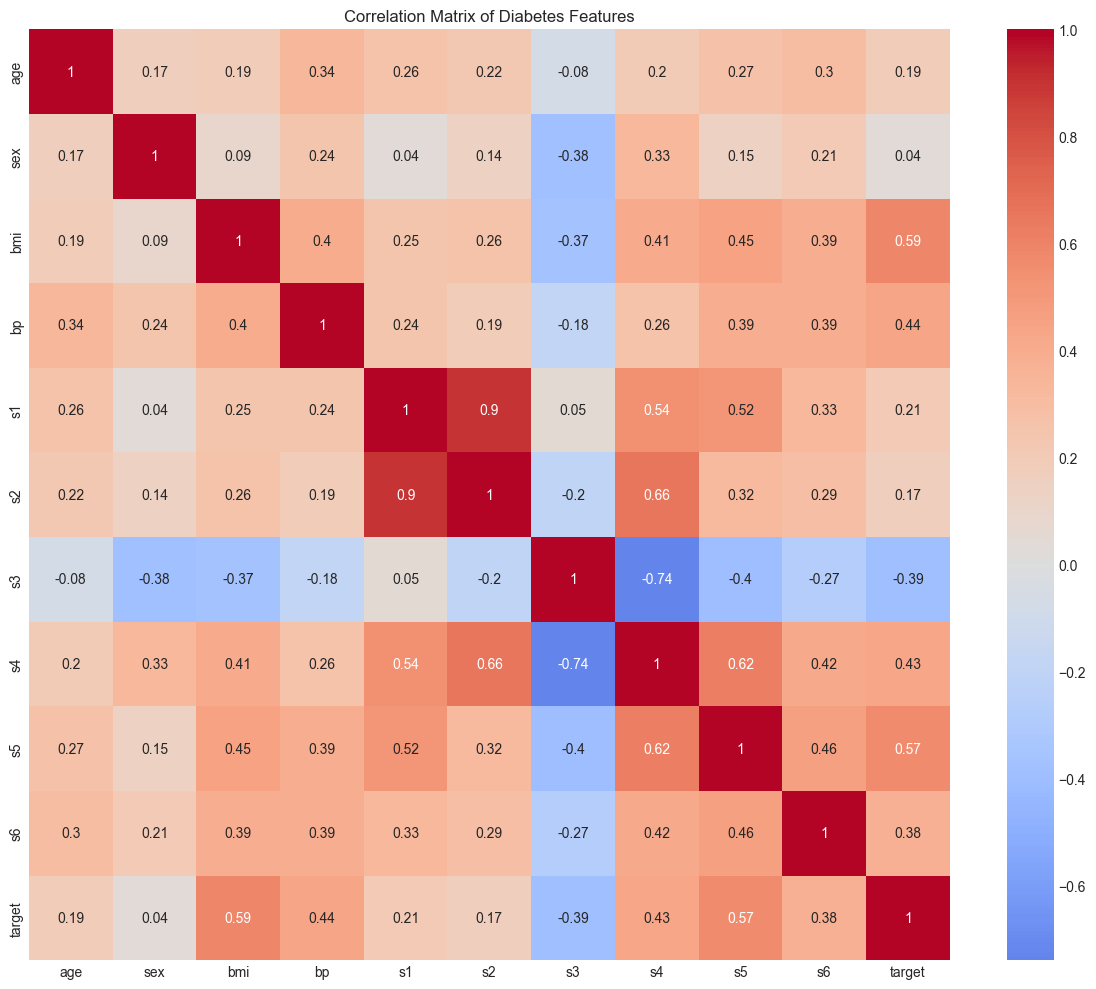

In [24]:
# Visualize correlations
plt.figure(figsize=(12, 10))
correlation_matrix = diabetes_df.corr().round(2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Diabetes Features')
plt.tight_layout()
plt.show()

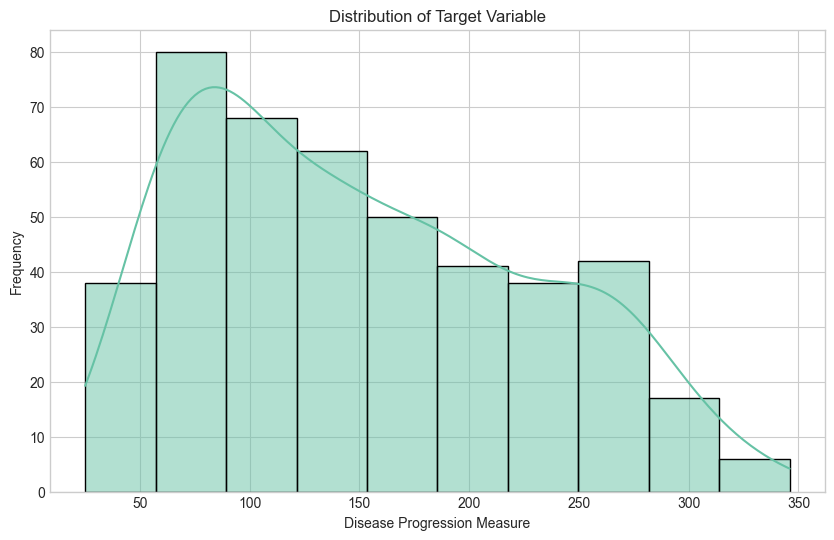

In [25]:
# Target distribution
plt.figure(figsize=(10, 6))
sns.histplot(diabetes_df['target'], kde=True)
plt.title('Distribution of Target Variable')
plt.xlabel('Disease Progression Measure')
plt.ylabel('Frequency')
plt.show()

### 2. Data Preprocessing

In [26]:
# Split the data into training and testing sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train_reg.shape}")
print(f"Testing set shape: {X_test_reg.shape}")

Training set shape: (353, 10)
Testing set shape: (89, 10)


In [27]:
# Feature scaling
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Convert back to DataFrames
X_train_reg_scaled_df = pd.DataFrame(X_train_reg_scaled, columns=X_reg.columns)
X_test_reg_scaled_df = pd.DataFrame(X_test_reg_scaled, columns=X_reg.columns)

print("First 5 rows of scaled training data:")
X_train_reg_scaled_df.head()

First 5 rows of scaled training data:


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,1.498365,1.061370,0.219902,1.138874,0.728473,1.055893,-0.824451,0.711038,0.547482,-0.061449
1,-0.228858,1.061370,-0.419366,-0.710591,-0.424929,0.272425,-1.529791,1.484286,-0.019757,0.367236
2,0.085182,-0.942179,1.018987,1.992473,-0.309589,-0.326699,-0.119111,-0.062210,0.331237,-0.318660
3,-0.621409,-0.942179,-0.784662,-0.639458,-1.174640,-1.215508,0.664600,-0.835458,-1.069682,-2.719299
4,-0.542899,-0.942179,-1.423930,-1.706457,-0.799784,-1.110167,1.291569,-1.608706,-0.802859,-0.918820


### 3. Building a Basic Decision Tree Regressor

In [28]:
# Initialize and train a basic decision tree regressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train_reg, y_train_reg)  # Using unscaled data for decision trees

# Make predictions
y_train_pred_reg = dt_reg.predict(X_train_reg)
y_test_pred_reg = dt_reg.predict(X_test_reg)

# Evaluate the model
train_mse_reg = mean_squared_error(y_train_reg, y_train_pred_reg)
test_mse_reg = mean_squared_error(y_test_reg, y_test_pred_reg)
train_r2_reg = r2_score(y_train_reg, y_train_pred_reg)
test_r2_reg = r2_score(y_test_reg, y_test_pred_reg)

print(f"Training MSE: {train_mse_reg:.4f}")
print(f"Testing MSE: {test_mse_reg:.4f}")
print(f"Training R²: {train_r2_reg:.4f}")
print(f"Testing R²: {test_r2_reg:.4f}")

Training MSE: 0.0000
Testing MSE: 4976.7978
Training R²: 1.0000
Testing R²: 0.0607


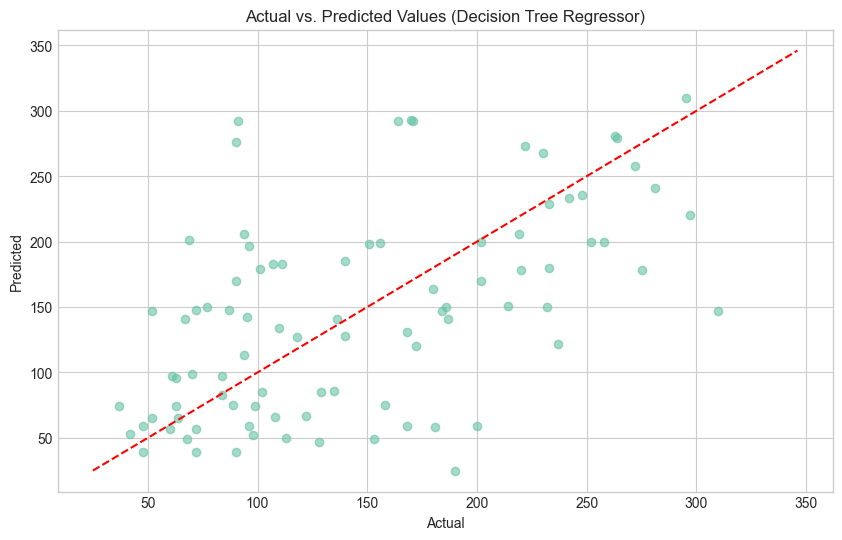

In [29]:
# Actual vs. Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_test_pred_reg, alpha=0.6)
plt.plot([y_reg.min(), y_reg.max()], [y_reg.min(), y_reg.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (Decision Tree Regressor)')
plt.show()

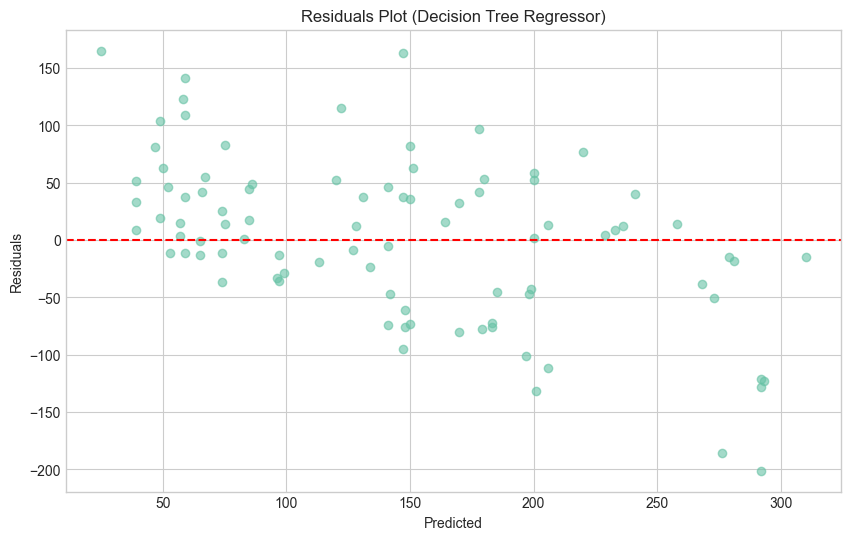

In [30]:
# Residuals Plot
residuals_reg = y_test_reg - y_test_pred_reg
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_reg, residuals_reg, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals Plot (Decision Tree Regressor)')
plt.show()

### 4. Hyperparameter Tuning

In [31]:
# Define hyperparameters grid
param_grid_reg = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['mse', 'friedman_mse', 'mae']
}

# GridSearchCV
grid_search_reg = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid_reg, cv=5, scoring='neg_mean_squared_error')
grid_search_reg.fit(X_train_reg, y_train_reg)

# Best parameters and score
print(f"Best parameters: {grid_search_reg.best_params_}")
print(f"Best cross-validation MSE: {-grid_search_reg.best_score_:.4f}")

# Best model
best_dt_reg = grid_search_reg.best_estimator_

Best parameters: {'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best cross-validation MSE: 4162.0223


In [32]:
# Evaluate the best model
y_train_pred_best_reg = best_dt_reg.predict(X_train_reg)
y_test_pred_best_reg = best_dt_reg.predict(X_test_reg)

best_train_mse_reg = mean_squared_error(y_train_reg, y_train_pred_best_reg)
best_test_mse_reg = mean_squared_error(y_test_reg, y_test_pred_best_reg)
best_train_r2_reg = r2_score(y_train_reg, y_train_pred_best_reg)
best_test_r2_reg = r2_score(y_test_reg, y_test_pred_best_reg)

print(f"Best Model Training MSE: {best_train_mse_reg:.4f}")
print(f"Best Model Testing MSE: {best_test_mse_reg:.4f}")
print(f"Best Model Training R²: {best_train_r2_reg:.4f}")
print(f"Best Model Testing R²: {best_test_r2_reg:.4f}")

Best Model Training MSE: 2937.5370
Best Model Testing MSE: 3390.5833
Best Model Training R²: 0.5166
Best Model Testing R²: 0.3600


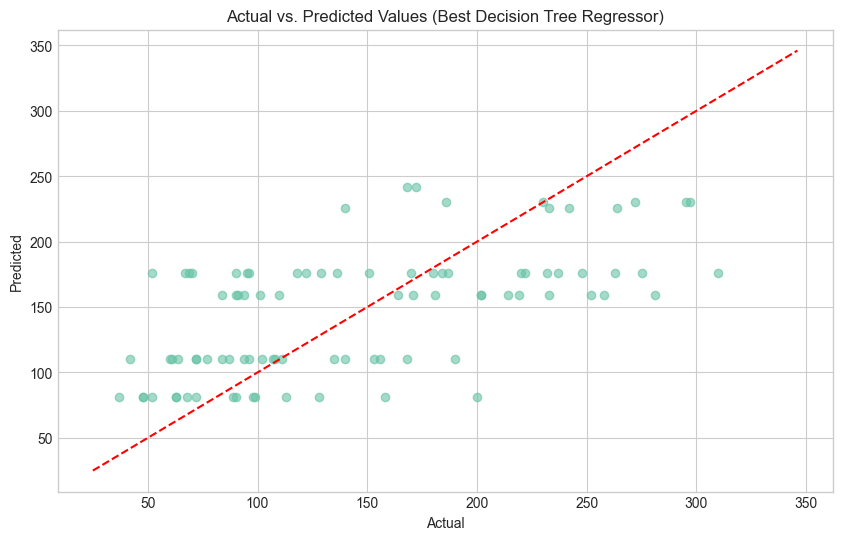

In [33]:
# Actual vs. Predicted Plot for Best Model
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_test_pred_best_reg, alpha=0.6)
plt.plot([y_reg.min(), y_reg.max()], [y_reg.min(), y_reg.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (Best Decision Tree Regressor)')
plt.show()

### 5. Feature Importance for Regression

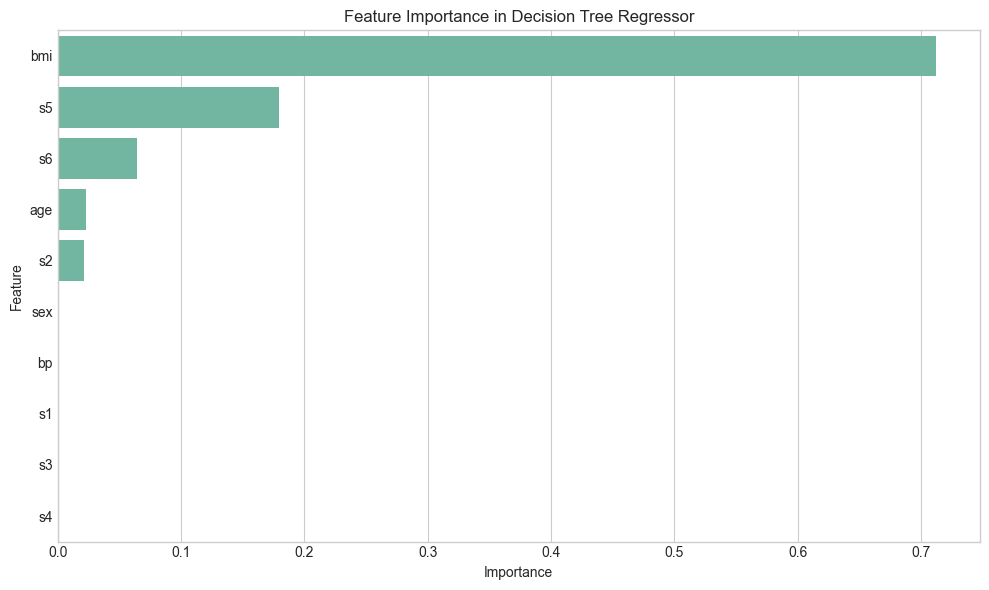

In [34]:
# Get feature importance
feature_importance_reg = pd.DataFrame({
    'Feature': diabetes.feature_names,
    'Importance': best_dt_reg.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_reg)
plt.title('Feature Importance in Decision Tree Regressor')
plt.tight_layout()
plt.show()

### 6. Cross-Validation and Learning Curves for Regression

In [35]:
# Perform 5-fold cross-validation
cv_scores_reg = cross_val_score(best_dt_reg, X_train_reg, y_train_reg, cv=5, scoring='neg_mean_squared_error')
cv_mse_reg = -cv_scores_reg
print(f"Cross-validation MSE scores: {cv_mse_reg}")
print(f"Mean CV MSE: {cv_mse_reg.mean():.4f}")
print(f"Standard deviation: {cv_mse_reg.std():.4f}")

Cross-validation MSE scores: [3967.33998151 5158.02467042 3516.99932374 4644.82557337 3522.92189388]
Mean CV MSE: 4162.0223
Standard deviation: 646.1463


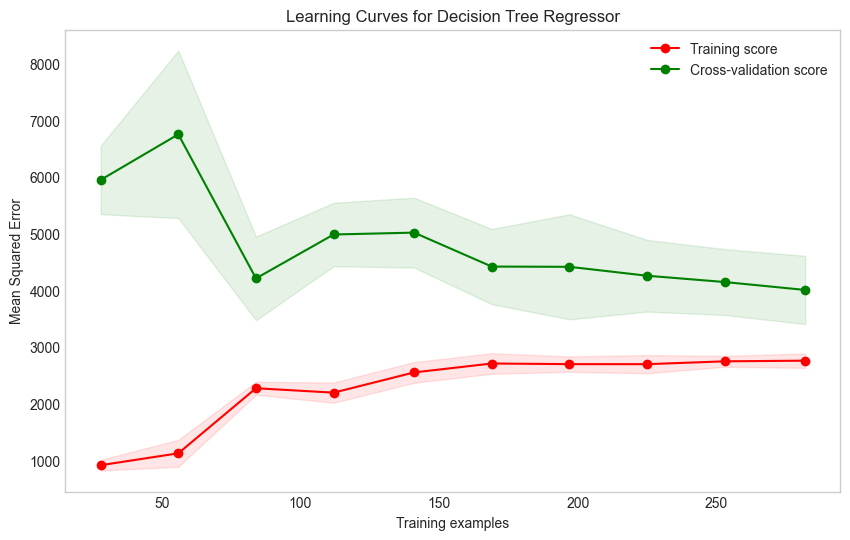

In [36]:
# Learning curve
train_sizes_reg, train_scores_reg, test_scores_reg = learning_curve(
    best_dt_reg, X_train_reg, y_train_reg, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error')

train_scores_mean_reg = -np.mean(train_scores_reg, axis=1)  # Negate to get positive MSE
train_scores_std_reg = np.std(train_scores_reg, axis=1)
test_scores_mean_reg = -np.mean(test_scores_reg, axis=1)  # Negate to get positive MSE
test_scores_std_reg = np.std(test_scores_reg, axis=1)

plt.figure(figsize=(10, 6))
plt.grid()
plt.fill_between(train_sizes_reg, train_scores_mean_reg - train_scores_std_reg,
                 train_scores_mean_reg + train_scores_std_reg, alpha=0.1, color="r")
plt.fill_between(train_sizes_reg, test_scores_mean_reg - test_scores_std_reg,
                 test_scores_mean_reg + test_scores_std_reg, alpha=0.1, color="g")
plt.plot(train_sizes_reg, train_scores_mean_reg, 'o-', color="r", label="Training score")
plt.plot(train_sizes_reg, test_scores_mean_reg, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curves for Decision Tree Regressor")
plt.xlabel("Training examples")
plt.ylabel("Mean Squared Error")
plt.legend(loc="best")
plt.show()

### 7. Export and Visualize the Regression Tree

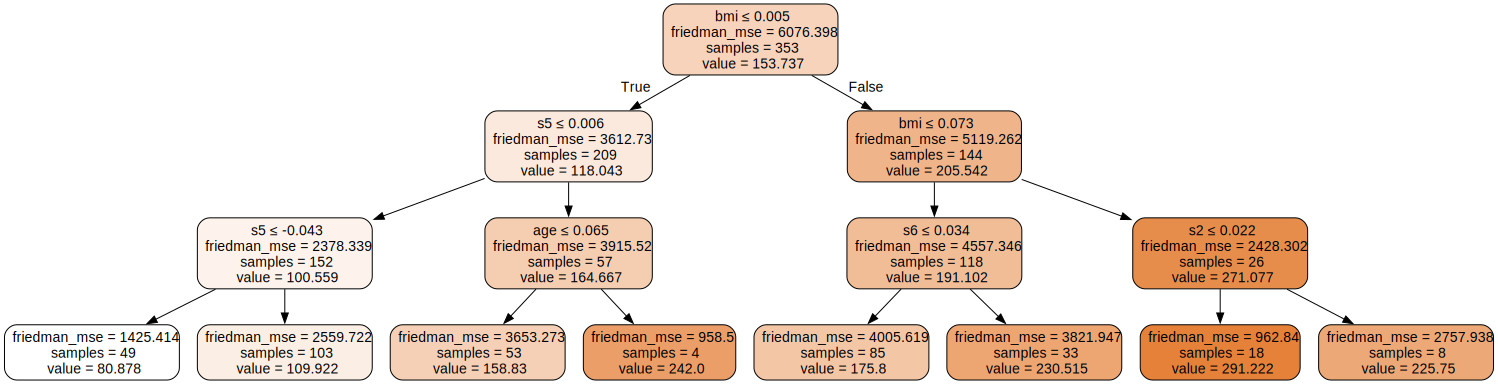

In [40]:
# Export the tree to a graphviz file
dot_data_reg = export_graphviz(best_dt_reg, out_file=None, 
                           feature_names=diabetes.feature_names,
                           filled=True, rounded=True, special_characters=True)

# Visualize the tree
graph_reg = graphviz.Source(dot_data_reg)
graph_reg

### 8. Save the Regression Model

In [38]:
# Save the model
joblib.dump(best_dt_reg, 'models/decision_tree_regressor.pkl')
print("Regressor model saved to 'models/decision_tree_regressor.pkl'")

Regressor model saved to 'models/decision_tree_regressor.pkl'


## Conclusion

In this notebook, we explored Decision Trees for both classification and regression tasks:

### Decision Tree Classification
- Used the Iris dataset to predict flower species based on 4 features.
- Started with a basic decision tree which achieved good accuracy but was potentially overfit.
- Optimized the model through hyperparameter tuning, finding the best values for `max_depth`, `min_samples_split`, `min_samples_leaf`, and `criterion`.
- Visualized the tree structure, decision boundaries, and feature importance.
- Used cross-validation and learning curves to assess model performance and stability.
- Saved the best model for future use.

### Decision Tree Regression
- Used the Diabetes dataset to predict disease progression based on 10 features.
- Evaluated performance using MSE and R² scores.
- Tuned hyperparameters to optimize performance, addressing the overfitting issues.
- Analyzed feature importance to understand which features most affect the prediction.
- Visualized learning curves to assess model behavior with different training set sizes.
- Created actual vs. predicted plots and residual plots to evaluate model quality.

### Key Insights
- Decision trees are powerful and interpretable models for both classification and regression tasks.
- They don't require feature scaling as they make decisions based on thresholds rather than distances.
- Without pruning or depth control, decision trees can easily overfit the training data.
- Hyperparameter tuning is crucial for achieving the right balance between bias and variance.
- Feature importance provides valuable insights into which variables are most predictive.

### Limitations and Considerations
- Decision trees can be unstable, where small changes in the data can lead to very different tree structures.
- They can create complex trees that don't generalize well (overfitting).
- For high-performance applications, ensemble methods like Random Forests or Gradient Boosting often outperform single decision trees.

In the next notebook, we'll explore Random Forests, which are ensemble learning methods that use multiple decision trees to improve prediction accuracy and control overfitting.